## Tutorial: Variational inference in a generalized linear mixed model

Adapted from [Tensorflow Probability's Linear Mixed Effects Model tutorial](https://www.tensorflow.org/probability/examples/Linear_Mixed_Effects_Model_Variational_Inference).
This tutorial demonstrates how to use Bean Machine's variational inference to perform uncertainty-aware
estimation in generalized linear models with both fixed and random effects.

## Prerequisites

In [75]:
import beanmachine.ppl as bm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.distributions as dist
from beanmachine.ppl.inference.vi import ADVI
from beanmachine.tutorials.utils.radon import load_data

sns.set_context('notebook')

## Data

We will consider variational inference (VI) against a regression model defined on the `radon` dataset.

In [76]:
df = load_data()
df.head()

,county_index,county,floor,activity,log_activity,Uppm,log_Uppm
0,0,AITKIN,1,2.2,0.832909,0.502054,-0.689048
1,0,AITKIN,0,2.2,0.832909,0.502054,-0.689048
2,0,AITKIN,0,2.9,1.098612,0.502054,-0.689048
3,0,AITKIN,0,1.0,0.095310,0.502054,-0.689048
4,1,ANOKA,0,2.8,1.064711,0.428565,-0.847313


Let's visualize the distribution over `floor` and `county`. There are two `floor`s with lots of data and many counties with little data.

/var/folders/f8/_w79hs797f5fp7nrm_2x_43r0000gn/T/ipykernel_89507/3673996874.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


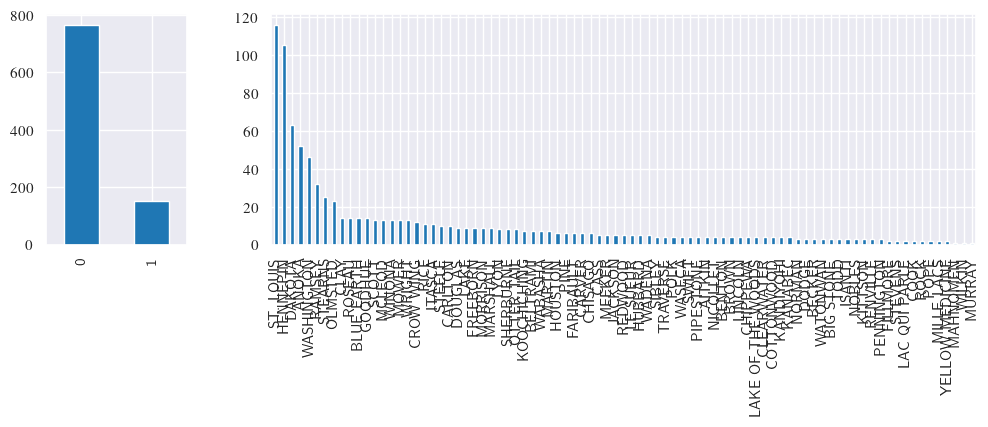

In [77]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(12, 3))
df['floor'].value_counts().plot(kind='bar', ax=ax[0])
df['county'].value_counts().plot(kind='bar', ax=ax[1])
fig.show()

## Model specification

Since many counties have little data, to avoid overfitting county effects we will model it as a random effect within a GLMM:

$$\log \text{radon}_j \sim c + \text{floor_effect}_j + \mathcal{N}(\text{county_effect}_j, \text{county_scale})$$

Note that the scale here is global across all counties and the random effect is normal; the [hierarchical linear mixed effects models](https://en.wikipedia.org/wiki/Hierarchical_generalized_linear_model) we will look at later will generalize this.

In [6]:
features = df[['county_index', 'floor']].astype(int)
labels = df[['log_activity']].astype(np.float32).values.flatten()
floor = torch.tensor(features.floor.values)
county_index = torch.tensor(features.county_index.values)

@bm.random_variable
def county_scale():
    return dist.HalfNormal(scale=1.)

@bm.random_variable
def intercept():
    return dist.Normal(loc=0., scale=1.)

@bm.random_variable
def floor_weight():
    return dist.Normal(loc=0., scale=1.)

@bm.random_variable
def county_prior():
    return dist.Independent(dist.Normal(
        loc=torch.zeros(county_index.unique().numel()),
        scale=county_scale(),
    ), 1)


@bm.random_variable
def linear_response():
    fixed_effect = intercept() + floor_weight() * floor
    random_effect = torch.gather(county_prior(), 0, county_index)
    return dist.Independent(dist.Normal(
        loc=fixed_effect + random_effect,
        scale=1.,
    ), 1)

## Variational inference

We will use ADVI to approximate the posterior. This method fits
a mean-field product of normals guide distribution using gradient
descent on a divegence measure between probability distributions. It
returns a distributional approximation which gives information on both
the parameter location as well as uncertainty in the estimate.

In [44]:
losses = []
v_world = ADVI(
    queries=[
        county_prior(),
        floor_weight(),
        intercept(),
        county_scale(),
    ],
    observations={
        linear_response(): torch.tensor(labels),
    },
    optimizer=lambda params: torch.optim.Adam(params, lr=5e-2),
).infer(
    num_steps=400,
    step_callback=lambda it, loss, vi_cls: losses.append(loss.item())
)


  0%|          | 0/400 [00:00<?, ?it/s]

We can verify that convergence is obtained by plotting the loss and checking that it is decreasing and saturating:

/var/folders/f8/_w79hs797f5fp7nrm_2x_43r0000gn/T/ipykernel_89507/2619671391.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


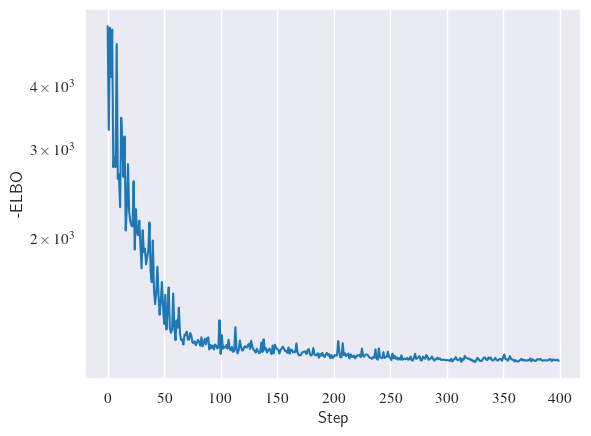

In [50]:
fig, ax = plt.subplots()
sns.lineplot(
    ax=ax,
    data=losses,
).set(
    yscale='log',
    xlabel='Step',
    ylabel='-ELBO',
)
fig.show()

## Inspecting posterior approximations

Our variational approximations for the linear fixed effects model

In [51]:
v_world.get_guide_distribution(intercept())

Normal(loc: 1.4739035367965698, scale: 0.07316000759601593)

In [52]:
v_world.get_guide_distribution(floor_weight())

Normal(loc: -0.6046578288078308, scale: 0.10657548159360886)

Since `county_scale()` is a `HalfNormal` with constrained support, following (Kucukelbir 2016, https://arxiv.org/abs/1603.00788)
its variational approximation is the pushfoward of a Normal under a support-transforming bijection. This is implemented using
a `torch.distributions.TransformedDistribution`.

In [55]:
v_world.get_guide_distribution(county_scale())

TransformedDistribution()

To estimate its shape, we Monte-Carlo approximate its first two moments:

In [60]:
scale_prior_sample = v_world.get_guide_distribution(county_scale()).sample((10_000,))
print(
    scale_prior_sample.mean(),
    scale_prior_sample.var(),
)

tensor(0.3270) tensor(0.0009)


## Visualizing results

Below we visualize the posterior county random effects estimated using ADVI. Since ADVI uses Gaussian guide distributions, uncertainty is
quantified and the plot below also plots the standard deviation for each county random effect.

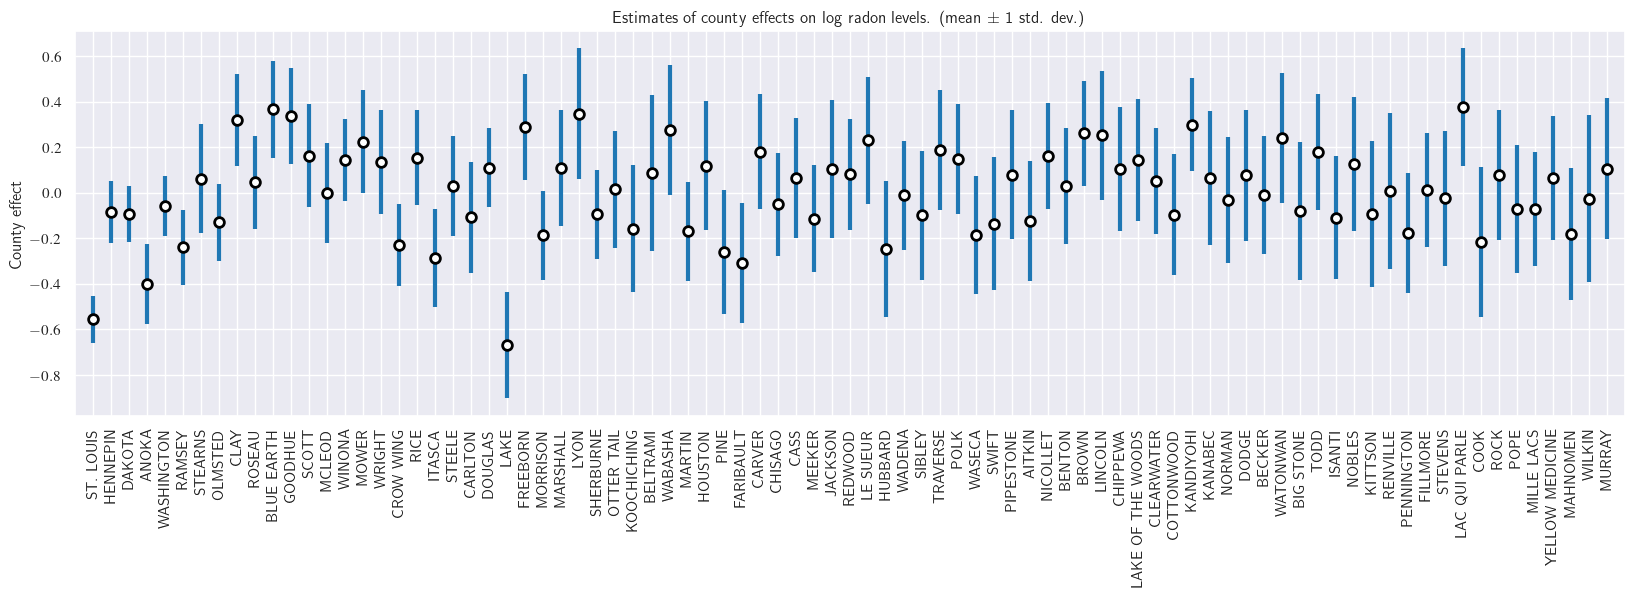

In [63]:
county_counts = (df.groupby(by=['county', 'county_index'], observed=True)
                   .agg('size')
                   .sort_values(ascending=False)
                   .reset_index(name='count'))

means = v_world.get_guide_distribution(county_prior()).base_dist.mean.detach().numpy()
stds = v_world.get_guide_distribution(county_prior()).base_dist.stddev.detach().numpy()

fig, ax = plt.subplots(figsize=(20, 5))

for idx, row in county_counts.iterrows():
  mid = means[row.county_index]
  std = stds[row.county_index]
  ax.vlines(idx, mid - std, mid + std, linewidth=3)
  ax.plot(idx, means[row.county_index], 'ko', mfc='w', mew=2, ms=7)

ax.set(
    xticks=np.arange(len(county_counts)),
    xlim=(-1, len(county_counts)),
    ylabel="County effect",
    title=r"Estimates of county effects on log radon levels. (mean $\pm$ 1 std. dev.)",
)
ax.set_xticklabels(county_counts.county, rotation=90);

One desirable heuristic of an uncertainty quantification method is that uncertainty should decrease with more data.
The plot below verifies this trend by plotting the estimated posterior uncertainty (i.e. ADVI Normal approximation's standard deviation)
versus the number of observations in that county. The size of each county implicitly affects the VI objective through the
data likelihood, and the plot below shows that an ELBO maximizing approximation in general assigns lower uncertainty to county
random effects with more data.
                                                                                    

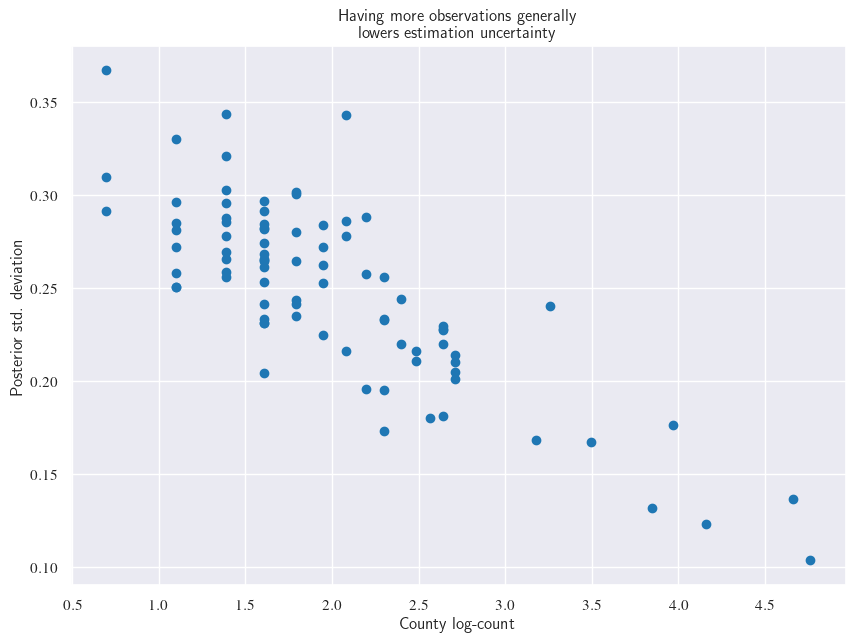

In [71]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.log1p(county_counts['count']), stds[county_counts.county_index], 'o')
ax.set(
    ylabel='Posterior std. deviation',
    xlabel='County log-count',
    title='Having more observations generally\nlowers estimation uncertainty'
);